In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

In [95]:
def sample_clayton(n, theta):
    W = np.random.gamma(shape=1/theta, scale=1, size=n)    
    E1 = np.random.exponential(scale=1, size=n)
    E2 = np.random.exponential(scale=1, size=n)
    U1 = (1 + E1 / W) ** (-1 / theta)
    U2 = (1 + E2 / W) ** (-1 / theta)
    return np.column_stack((U1, U2))
    
n_samples = 1000
k1, k2 = 1.5, 2.5
lam1, lam2 = 1.0, 2.0
theta = 3.0

samples = sample_clayton(n_samples, theta)

t1 = weibull_min.ppf(samples[:, 0], k1, scale=lam1)
t2 = weibull_min.ppf(samples[:, 1], k2, scale=lam2)

t = np.min([t1, t2], axis=0)
i = np.argmin([t1, t2], axis=0)

/var/folders/g2/byydgcq968178bg657rkq50h0000gn/T/ipykernel_69682/3064972615.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.tight_layout(); fig.show()


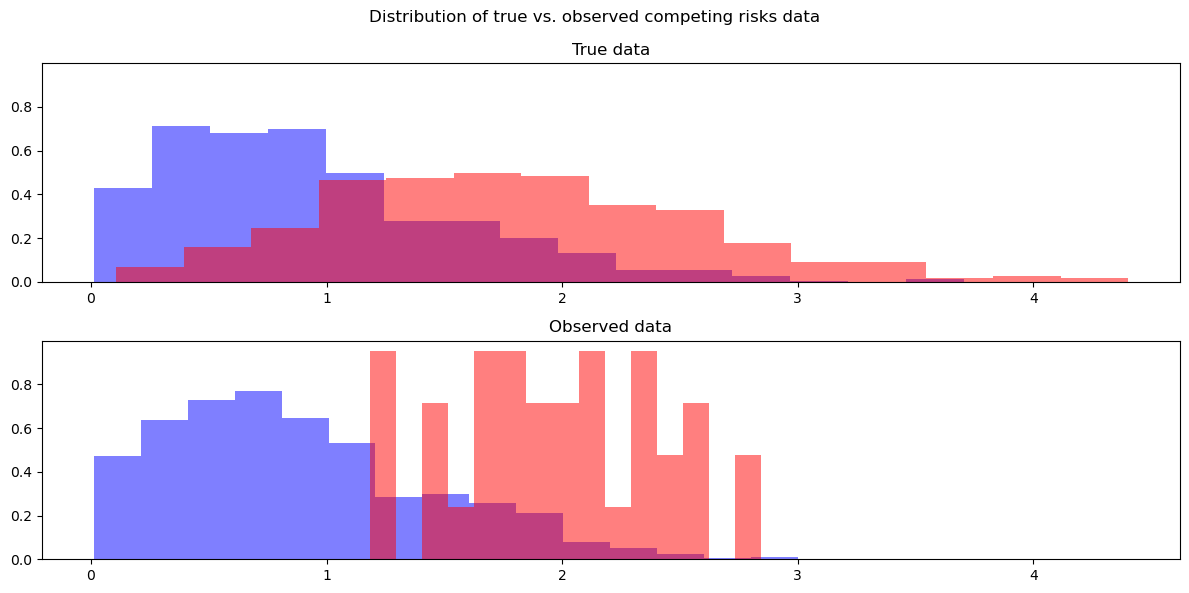

In [96]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6))
ax0.sharex(ax1); ax0.sharey(ax1)

ax0.set_title('True data')
ax0.hist(t1, bins=15, density=True, alpha=0.5, color='blue')
ax0.hist(t2, bins=15, density=True, alpha=0.5, color='red')

ax1.set_title('Observed data')
ax1.hist(t[i == 0], bins=15, alpha=0.5, color='blue', density=True)
ax1.hist(t[i == 1], bins=15, alpha=0.5, color='red', density=True)

fig.suptitle('Distribution of true vs. observed competing risks data')
fig.tight_layout(); fig.show()

In [97]:
imputed = np.zeros((n_samples, 2))
for idx in range(len(t)):
    if i[idx] == 0:
        u1 = weibull_min.cdf(t[idx], c=k1, scale=lam1)
    else:
        u1 = weibull_min.cdf(t[idx], c=k2, scale=lam2)
    u2 = np.random.uniform(u1, 1)

    if i[idx] == 0:
        imputed[idx, 0] = u1
        imputed[idx, 1] = u2
    else:
        imputed[idx, 0] = u2
        imputed[idx, 1] = u1

from copulas.bivariate import Clayton
copula = Clayton()
copula.fit(imputed)

print(f"Naive theta: {copula.theta:.4f}")

Naive theta: 1.6876


In [ ]:
def weibull_pdf(t, lmbda, k):
    return (k / lmbda) * (t / lmbda)**(k - 1) * np.exp(-(t / lmbda)**k)

def weibull_sf(t, lmbda, k):
    return np.exp(-(t / lmbda)**k)

def partial_derivative(u1, u2, theta):
    A = np.power(u2, -theta - 1)
    if (A == np.inf).any():
        return np.zeros(len(u2))
    B = np.power(u2, -theta) + np.power(u1, -theta) - 1
    h = np.power(B, (-1 - theta) / theta)
    return A * h

def neg_log_likelihood(params):
    theta, lmbda1, k1, lmbda2, k2 = params
    if lmbda1 <= 0 or k1 <= 0 or lmbda2 <= 0 or k2 <= 0:
        return np.inf
    
    copula = Clayton()
    copula.theta = theta

    u1 = weibull_min.cdf(t, c=k1, scale=lam1)
    u2 = weibull_min.cdf(t, c=k2, scale=lam2)

    f1 = partial_derivative(u1, u2, theta)
    f2 = partial_derivative(u2, u1, theta)

    likelihoods = np.where(i == 0, f1, f2)
    likelihoods = np.clip(likelihoods, 1e-10, None)
    return -np.sum(np.log(likelihoods))

from scipy.optimize import minimize
pars = [lam1, k1, lam2, k2]
initial_guess = 3.0
bounds = [(0, None)]
result = minimize(lambda th: neg_log_likelihood([th] + pars), initial_guess, bounds=bounds)

print("Estimated parameters:")
print(f"Theta: {result.x[0]:.4f}")

Estimated parameters:
Theta: 2.6523


In [103]:
np.array([2.6671, 2.3714, 2.2634, 2.5970, 2.2892, 2.4253, 2.5140, 2.3592, 2.6694, 2.6523]).std()

0.15103081175707161